<a href="https://colab.research.google.com/github/sagnikCodes/Adding_Features_To_data.csv/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np 
import pandas as pd 
import math 
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.optimizers import Adam
import keras_tuner as kt
import yfinance as yf
import datetime
import time
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

In [79]:
company_name = input('Enter company name: ')
current_timestamp = int(time.time())
years_back=20
ten_years_ago = datetime.datetime.now() - datetime.timedelta(days=365*years_back)
start_timestamp = int(ten_years_ago.timestamp())
url = f'https://query1.finance.yahoo.com/v7/finance/download/{company_name}.NS?period1={start_timestamp}&period2={current_timestamp}&interval=1d&events=history&includeAdjustedClose=true'

Enter company name: adaniports


In [80]:
#So, we extract Closing Price of Stock Price
data=pd.read_csv(url)['Close']

In [81]:
if(data.isnull().sum()!=0):
  data.interpolate(method='linear', inplace=True)

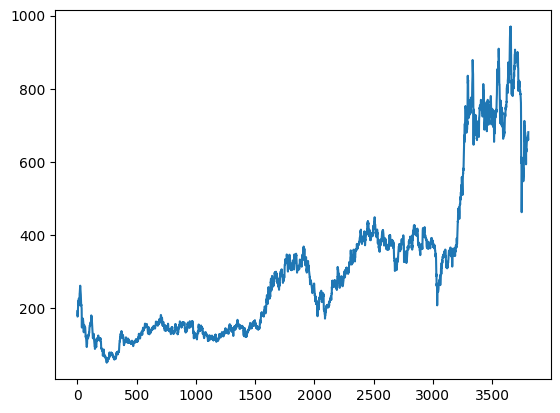

In [82]:
plt.plot(data)

In [83]:
train,test,validation=data[0:int(0.7*len(data))],data[int(0.7*len(data)):int(0.9*len(data))],data[int(0.9*len(data)):len(data)]

In [84]:
training_data=np.array([train]).T
validation_data=np.array([validation]).T
testing_data=np.array([test]).T

In [85]:
scaler=StandardScaler()
training_data=scaler.fit_transform(training_data)
validation_data=scaler.fit_transform(validation_data)
testing_data=scaler.fit_transform(testing_data)

In [86]:
def create_data(data,time_step=1): 
    x = [] 
    y = []
    for i in range(len(data)-time_step-1):
        x.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [87]:
time_step=100
X_train,Y_train = create_data(training_data,time_step)  
X_test,Y_test = create_data(testing_data,time_step)  
X_valid, Y_valid = create_data(validation_data,time_step)

In [88]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1] , 1)

In [89]:
X_train.shape

(2563, 100, 1)

In [90]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers',1,10)):
        if i == 0:
            model.add(GRU(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(GRU(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                   return_sequences=True))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units_last', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hp.Float('dropout_last', 0, 0.5, step=0.1)))
    model.add(Dense(units=1,activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model

In [91]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='Stock_Market_LSTM',
    project_name='my_project'
)
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [92]:
tuner.search(x=X_train,y=Y_train,
             epochs=5,
             validation_data=(X_valid,Y_valid),
             callbacks=[early_stopping]
        )

In [93]:
best_hp=tuner.get_best_hyperparameters()[0]
model=build_model(best_hp)

In [94]:
model.fit(X_train,Y_train,epochs=100,initial_epoch=5 ,validation_data=(X_valid,Y_valid),callbacks=early_stopping)

Epoch 6/100
81/81 [==============================] - 14s 84ms/step - loss: 0.0787 - mae: 0.1975 - val_loss: 0.3395 - val_mae: 0.4037
Epoch 7/100
81/81 [==============================] - 3s 36ms/step - loss: 0.0311 - mae: 0.1324 - val_loss: 0.2441 - val_mae: 0.3320
Epoch 8/100
81/81 [==============================] - 3s 38ms/step - loss: 0.0298 - mae: 0.1320 - val_loss: 0.2178 - val_mae: 0.3135
Epoch 9/100
81/81 [==============================] - 4s 52ms/step - loss: 0.0301 - mae: 0.1304 - val_loss: 0.2309 - val_mae: 0.3183
Epoch 10/100
81/81 [==============================] - 3s 33ms/step - loss: 0.0264 - mae: 0.1228 - val_loss: 0.1827 - val_mae: 0.2877
Epoch 11/100
81/81 [==============================] - 3s 36ms/step - loss: 0.0194 - mae: 0.1060 - val_loss: 0.1824 - val_mae: 0.2846
Epoch 12/100
81/81 [==============================] - 2s 30ms/step - loss: 0.0192 - mae: 0.1037 - val_loss: 0.1629 - val_mae: 0.2772
Epoch 13/100
81/81 [==============================] - 2s 28ms/step - los

In [95]:
train_predict=model.predict(X_train)
valid_predict=model.predict(X_valid)

9/9 [==============================] - 0s 10ms/step


In [96]:
train_predict=scaler.inverse_transform(train_predict)
valid_predict=scaler.inverse_transform(valid_predict)

In [97]:
train_predict.shape

(2563, 1)

In [98]:
Y_train = Y_train.reshape(len(Y_train),1)

In [99]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

481.4661482531057

In [100]:

math.sqrt(mean_squared_error(Y_valid,valid_predict))

492.26133623461806

[[-0.72914785]
 [-0.63508852]
 [-0.58635411]
 ...
 [ 1.68450927]
 [ 1.73916012]
 [ 1.79531476]]


Text(0.5, 1.0, 'Training dataset prediction')

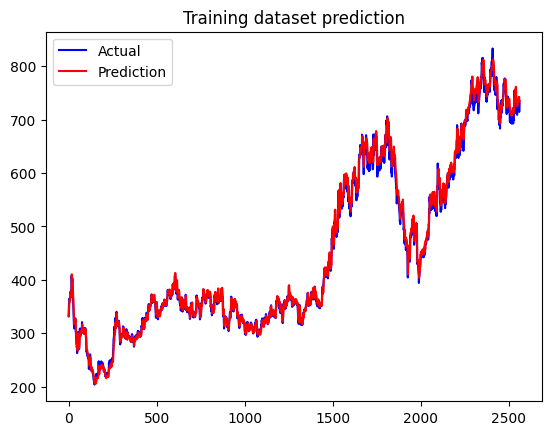

In [101]:
print(Y_train) 
Y_train = scaler.inverse_transform(Y_train)
plt.plot(Y_train,color = "blue" , label = 'Actual') 
plt.plot(train_predict,color = "red" , label = 'Prediction') 
plt.legend() 
plt.title("Training dataset prediction")

Text(0.5, 1.0, 'Validatoin dataset ')

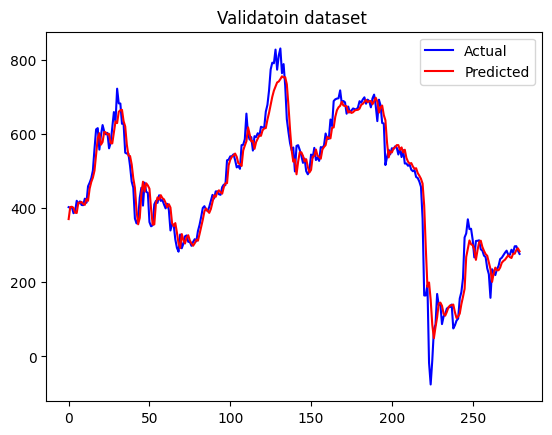

In [102]:
Y_valid = Y_valid.reshape(len(Y_valid),1)
Y_valid = scaler.inverse_transform(Y_valid)
plt.plot(Y_valid,color = "blue" , label = 'Actual')  
plt.plot(valid_predict,color = "red" , label = 'Predicted') 
plt.legend() 
plt.title("Validatoin dataset ")

In [103]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

21/21 [==============================] - 0s 10ms/step


In [104]:
Y_test = Y_test.reshape(len(Y_test),1) 
Y_test=scaler.inverse_transform(Y_test)

Text(0.5, 1.0, 'Testing data')

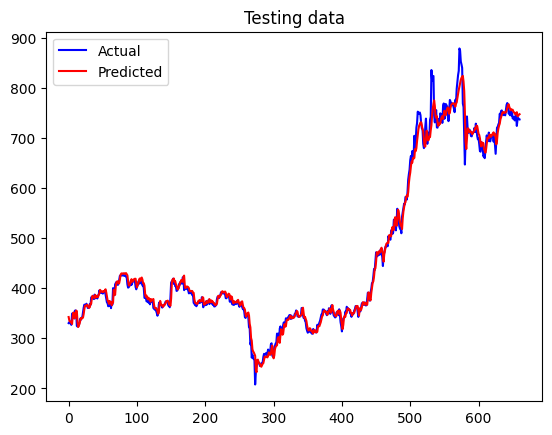

In [105]:
plt.plot(Y_test,color = "blue" , label =  'Actual')  
plt.plot(test_predict,color = "red" , label = 'Predicted') 
plt.legend() 
plt.title("Testing data")